In [1]:
import xtrack as xt
import xpart as xp
import xobjects as xo

import matplotlib.pyplot as plt

import json
from numpy import random
import random
import numpy as np

from cpymad.madx import Madx

import scipy as sp

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Constants

In [2]:
REL_GAMMA = 25.598474067
REL_BETA = np.sqrt(1-REL_GAMMA**(-2))

exn = 1.5e-6
eyn = 1.5e-6
ex = exn/(REL_BETA*REL_GAMMA)
ey = eyn/(REL_BETA*REL_GAMMA)

p = 24 # beam momentum (GeV/c)
momentum = 24 # beam momentum (GeV/c)
Brho = 24*3.3356

PS_radius = 70.079

TUNE_TARGET = 6.2

SEPTA = True

# Load PS at East Extraction

In [3]:
mad = Madx(stdout=True)

PS_REPO = "../../../../models/acc-models-ps/"

mad.call(PS_REPO+"ps_mu.seq")
mad.call(PS_REPO+"ps_ss.seq")
mad.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

mad.command.beam(
    particle="PROTON",
    pc = p,
    ex = ex,
    ey = ey
)
mad.input(f"BRHO      := BEAM->PC * 3.3356;")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')
twiss_initial = mad.twiss().dframe() 


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.08.01  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2022.02.25               +
  + Execution date: 2023.03.13 14:25:12      +
  ++++++++++++++++++++++++++++++++++++++++++++
/**********************************************************************************

*

* Elements description and sequence file for each PS main unit (MU).

*

* 07/10/2020 - Alexander Huschauer

************************************************************************************/



/************************************************************************************

*

*         DEFINITION OF FOCUSING AND DEFOCUSING HALF-UNITS OF THE MU               

*

*************************************************************************************/



/************************************************************************************

*        							 F HALF-UNITS     					            

***********************

In [4]:
def tune_match(Qx,Qxp,Qy,Qyp,momentum,ex,ey):
    
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    # Call latice files
    madx.call(PS_REPO+"ps_mu.seq")
    madx.call(PS_REPO+"ps_ss.seq")
    madx.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

    madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.use(sequence = "PS")
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.input('savebeta, label=bumped23, place = PR.BPM23;')
    twiss_initial = madx.twiss().dframe()
    len_ps = twiss_initial.s[-1]

    ### Cycle sequence, changing starting point and adding markers at around the magnet 62
    madx.input('SEQEDIT, sequence=PS;')
    madx.input('FLATTEN;')
    madx.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
    madx.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
    madx.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence = "PS")

    twiss_cycled = madx.twiss().dframe()
    
    madx.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
      ptc_create_universe;
      ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
      IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
      }
      ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
      }
      ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    madx.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    madx.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    madx.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    madx.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    madx.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    madx.use(sequence="PS")
    twiss_tune_matching = madx.twiss().dframe() # Needed to refresh the tune values
    madx.input('qx = table(SUMM, Q1);')
    madx.input('qy = table(SUMM, Q2);')
    madx.input('qxp = table(SUMM, DQ1);')
    madx.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": madx.globals["qx"], "Qy": madx.globals["qy"], "Qxp": madx.globals["qxp"], "Qyp": madx.globals["qyp"]}
    pfw_dict = {"k1prpfwf": madx.globals["k1prpfwf"], "k1prpfwd": madx.globals["k1prpfwd"], "k2prpfwf": madx.globals["k2prpfwf"], "k2prpfwd": madx.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")

    madx.quit()
    
    return pfw_dict, tune_info_dict

In [5]:
def tune_match_thin(Qx,Qxp,Qy,Qyp,momentum,ex,ey):
    
    with open('tempfile', 'w') as f:
        madx = Madx(stdout=f,stderr=f)
        madx.option(verbose=True, debug=False, echo=True, warn=True, twiss_print=False)

    # Call latice files
    madx.call(PS_REPO+"ps_mu.seq")
    madx.call(PS_REPO+"ps_ss.seq")
    madx.call(PS_REPO+"scenarios/east/4_slow_extraction/ps_se_east.str")

    madx.command.beam(particle='PROTON',pc="24",ex=ex,ey=ey)
    madx.input('BRHO      := BEAM->PC * 3.3356;')

    madx.use(sequence = "PS")
    madx.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
    madx.input('savebeta, label=bumped23, place = PR.BPM23;')
    twiss_initial = madx.twiss().dframe()
    len_ps = twiss_initial.s[-1]

    ### Cycle sequence, changing starting point and adding markers at around the magnet 62
    madx.input('SEQEDIT, sequence=PS;')
    madx.input('FLATTEN;')
    madx.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
    madx.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
    madx.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
    madx.input('FLATTEN;')
    madx.input('ENDEDIT;')
    madx.use(sequence = "PS")

    madx.use(sequence='ps')
    madx.select(flag='makethin', class_='rbend', slice_=4)
    madx.select(flag='makethin', class_='quadrupole', slice_=4)
    madx.select(flag='makethin', class_='sbend', slice_=4)
    madx.select(flag='makethin', class_='sextupole', slice_=2)
    madx.makethin(sequence='ps')

    twiss_cycled = madx.twiss().dframe()
    
    madx.input('''
    ptc_twiss_macro(order, dp, slice_flag): macro = {
      ptc_create_universe;
      ptc_create_layout, time=false, model=2, exact=true, method=6, nst=3;
      IF (slice_flag == 1){
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,l,x,px,beta11,beta22,disp1,k1l;
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, slice_magnets=true;
      }
      ELSE{
        select, flag=ptc_twiss, clear;
        select, flag=ptc_twiss, column=name,keyword,s,x,px,beta11,alfa11,beta22,alfa22,disp1,disp2,mu1,mu2,energy,l,angle,K1L,K2L,K3L,HKICK,SLOT_ID;    
        ptc_twiss, closed_orbit, icase=56, no=order, deltap=dp, table=ptc_twiss, summary_table=ptc_twiss_summary, normal;
      }
      ptc_end;
    };

    ''')
    
    #/**********************************************************************************
    # *                        Matching using the PFW
    #***********************************************************************************/
    madx.input("Qx   := "+str(Qx)+"; !Horizontal Tune")
    madx.input("Qxp  := "+str(Qxp)+"; !Horizontal Chromaticity")

    madx.input("Qy   := "+str(Qy)+"; !Vertical Tune")
    madx.input("Qyp  := "+str(Qyp)+"; !Vertical Chromaticity")

    madx.input('''
    use, sequence=PS;
    match, use_macro;
            vary, name = k1prpfwf;
            vary, name = k1prpfwd;
            vary, name = k2prpfwf;
            vary, name = k2prpfwd;
            use_macro, name = ptc_twiss_macro(2,0,0);
            constraint, expr = table(ptc_twiss_summary,Q1)  = Qx;
            constraint, expr = table(ptc_twiss_summary,Q2)  = Qy;
            constraint, expr = table(ptc_twiss_summary,DQ1) = Qxp;
            constraint, expr = table(ptc_twiss_summary,DQ2) = Qyp;
    jacobian,calls=50000,bisec=3;
    ENDMATCH;
    ''')
    
    madx.use(sequence="PS")
    twiss_tune_matching = madx.twiss().dframe() # Needed to refresh the tune values
    madx.input('qx = table(SUMM, Q1);')
    madx.input('qy = table(SUMM, Q2);')
    madx.input('qxp = table(SUMM, DQ1);')
    madx.input('qyp = table(SUMM, DQ2);')
    
    tune_info_dict = {"Qx": madx.globals["qx"], "Qy": madx.globals["qy"], "Qxp": madx.globals["qxp"], "Qyp": madx.globals["qyp"]}
    pfw_dict = {"k1prpfwf": madx.globals["k1prpfwf"], "k1prpfwd": madx.globals["k1prpfwd"], "k2prpfwf": madx.globals["k2prpfwf"], "k2prpfwd": madx.globals["k2prpfwd"]}

    print (f"H-tune: {round(tune_info_dict['Qx'],3)}, H-Chroma: {round(tune_info_dict['Qxp'],3)}\nV-Tune: {round(tune_info_dict['Qy'],3)}, V-Chroma: {round(tune_info_dict['Qyp'],3)}")
    print (f"")
    print (f"PFW settings: \n  k1prpfwf: {round(pfw_dict['k1prpfwf'],6)}\n  k1prpfwd: {round(pfw_dict['k1prpfwd'],6)}\n  k2prpfwf: {round(pfw_dict['k2prpfwf'],6)}\n  k2prpfwd: {round(pfw_dict['k2prpfwd'],6)}")

    madx.quit()
    
    return pfw_dict, tune_info_dict

# PFW Settings for Tune Target

In [6]:
thin_pfw, thin_info = tune_match_thin(Qx=TUNE_TARGET%6,Qxp=-1.239,Qy=0.3,Qyp=-0.242, momentum=24, ex=ex, ey=ey)

H-tune: 6.2, H-Chroma: -1.238
V-Tune: 6.3, V-Chroma: -0.242

PFW settings: 
  k1prpfwf: -0.000236
  k1prpfwd: -4.2e-05
  k2prpfwf: 0.011543
  k2prpfwd: -0.020273


# Set PFWs, Cycle & Flatten

In [7]:
mad.input("k1prpfwf = "+str(thin_pfw["k1prpfwf"])+";")
mad.input("k1prpfwd = "+str(thin_pfw["k1prpfwd"])+";")
mad.input("k2prpfwf = "+str(thin_pfw["k2prpfwf"])+";")
mad.input("k2prpfwd = "+str(thin_pfw["k2prpfwd"])+";")
mad.use(sequence="PS")
mad.input('SELECT, FLAG=TWISS, COLUMN=NAME,KEYWORD,S,L,K1L,KEYWORD,BETX,ALFX,X,DX,PX,DPX,MUX,BETY,ALFY,Y,DY,PY,DPY,MUY,APERTYPE,APER_1,APER_2,APER_3,APER_4,KMIN,RE11,RE12,RE21,RE22,RE33,RE34,RE43,RE44,RE16,RE26;')
mad.input('savebeta, label=bumped23, place = PR.BPM23;')
twiss_initial = mad.twiss().dframe()
len_ps = twiss_initial.s[-1]

mad.input('SEQEDIT, sequence=PS;')
mad.input('FLATTEN;')
mad.command.install(element = 'marker_ss62_end', class_='MARKER', at=0, from_='SS62$END')
mad.command.install(element = 'marker_ss63_start', class_='MARKER', at=0, from_='SS63$START')
mad.input('CYCLE, START=PR.BPM23;') # This will be the place to start the ejection sequence
mad.input('FLATTEN;')
mad.input('ENDEDIT;')

mad.use(sequence = "PS")
twiss_cycled = mad.twiss().dframe()


++++++ info: k1prpfwf redefined
++++++ info: k1prpfwd redefined
++++++ info: k2prpfwf redefined
++++++ info: k2prpfwd redefined
enter Twiss module
  
iteration:   1 error:   8.362876E-04 deltap:   0.000000E+00
orbit:   3.737682E-03  8.422421E-05  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   8.957737E-05 deltap:   0.000000E+00
orbit:   3.679054E-03  8.622555E-05  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   3 error:   4.166095E-08 deltap:   0.000000E+00
orbit:   3.679059E-03  8.622425E-05  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
          628.3185                 -0      0.02644167461        6.149722537 

                q1                dq1            betxmax              dxmax 
       6.237265978        4.147710853        37.18548886        4.366234973 

             dxrms             xcomax             xcorms 

/opt/homebrew/Caskroom/miniconda/base/envs/cern/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


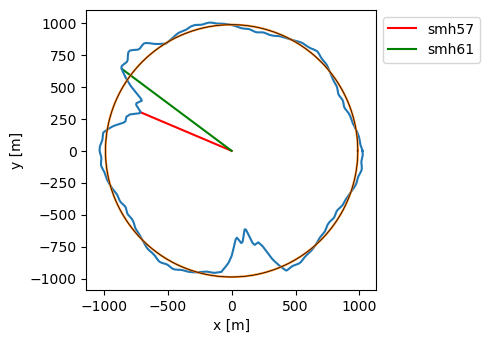

In [8]:
from matplotlib import patches
c = twiss_initial.s[-1]
r = c/2*np.pi

fig, ax = plt.subplots(tight_layout=True, figsize=(5, 5))

x_x = []
x_y = []
for i in range(len(twiss_initial)):
    x = (r+10000*twiss_initial.x[i])*np.cos(twiss_initial.s[i]*2*np.pi/c)
    y = (r+10000*twiss_initial.x[i])*np.sin(-twiss_initial.s[i]*2*np.pi/c) # Clockwise
    x_x.append(x)
    x_y.append(y)

y_x = []
y_y = []
for i in range(len(twiss_initial)):
    x = (r+10000*twiss_initial.y[i])*np.cos(twiss_initial.s[i]*2*np.pi/c)
    y = (r+10000*twiss_initial.y[i])*np.sin(-twiss_initial.s[i]*2*np.pi/c) # Clockwise
    y_x.append(x)
    y_y.append(y)

theta = twiss_initial.s*2*np.pi/c
x = r*np.cos(theta)
y = r*np.sin(theta)

loc_57 = twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['s']
x_57 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['x'])*np.cos(loc_57*2*np.pi/c)
y_57 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh57:1']['x'])*np.sin(-loc_57*2*np.pi/c) # Clockwise
# mark 57
ax.plot([0, x_57], [0, y_57], color='red', label='smh57')


loc_61 = twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['s']
x_61 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['x'])*np.cos(loc_61*2*np.pi/c)
y_61 = (r+10000*twiss_initial.loc[twiss_initial['name'] == 'pe.smh61:1']['x'])*np.sin(-loc_61*2*np.pi/c) # Clockwise
# mark 61
ax.plot([0, x_61], [0, y_61], color='green', label='smh61')


ax.plot(x_x,x_y)
ax.plot(y_x,y_y)
ax.plot(x, y, color="k", lw=0.5)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect("equal")
ax.legend()
# legend top right
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Enable Extraction Bump

In [9]:
# Initialise Septum strength
mad.input('PE.SEH23 , KICK := kPESEH23')
mad.input('PE.SMH57 , KICK := kPESMH57')
mad.input('PE.SMH61 , KICK := kPESMH61')
mad.input('kPESEH23 = 0.0;')
mad.input('kPESMH57 = 0.0;')
mad.input('kPESMH61 = 0.0;')

voltage_seh23=-177e3
smh57_current=9120
smh61_current=1170

if SEPTA == True:
    print("SEPTA ENABLED")
    # Electrostatic septum strength
    gap_seh23 = (88.11-73.00)/1000 # [m]
    Efield = voltage_seh23/gap_seh23
    effective_length = 0.8 # [m]
    seh23_strength = np.arctan( (abs(Efield)*effective_length)/ (p*1e9*REL_BETA) )
    mad.input('kPESEH23 = '+str(-seh23_strength)+';')
#         madx.input('kPESEH23 = '+str(-0.00039076814944217255)+';')

    # Magnetic septums strength
    smh57_strength = (smh57_current*(378e-3/9871))/Brho # Scaling from codilog
    smh61_strength = (smh61_current*(0.247/2350))/Brho  # Scaling from codilog
    mad.input('kPESMH57 = '+str(smh57_strength)+';')
    mad.input('kPESMH61 = '+str(smh61_strength)+';')
#         madx.input('kPESMH57 = '+str(0.004362548612318965)+';')
#         madx.input('kPESMH61 = '+str(0.0015361362783945214)+';')
    
    print(f"SEH23 = {voltage_seh23} V, SMH57 = {smh57_current} A, SMH61 = {smh61_current} A")

SEPTA ENABLED
++++++ info: kpeseh23 redefined
++++++ info: kpesmh57 redefined
++++++ info: kpesmh61 redefined
SEH23 = -177000.0 V, SMH57 = 9120 A, SMH61 = 1170 A


In [10]:
# c = twiss_bump.s[-1]
# r = c/2*np.pi

# fig, ax = plt.subplots(tight_layout=True, figsize=(5, 5))

# x_x = []
# x_y = []
# for i in range(len(twiss_bump)):
#     x = (r+10000*twiss_bump.x[i])*np.cos(twiss_bump.s[i]*2*np.pi/c)
#     y = (r+10000*twiss_bump.x[i])*np.sin(-twiss_bump.s[i]*2*np.pi/c) # Clockwise
#     x_x.append(x)
#     x_y.append(y)

# y_x = []
# y_y = []
# for i in range(len(twiss_bump)):
#     x = (r+10000*twiss_bump.y[i])*np.cos(twiss_bump.s[i]*2*np.pi/c)
#     y = (r+10000*twiss_bump.y[i])*np.sin(-twiss_bump.s[i]*2*np.pi/c) # Clockwise
#     y_x.append(x)
#     y_y.append(y)

# theta = twiss_bump.s*2*np.pi/c
# x = r*np.cos(theta)
# y = r*np.sin(theta)

# loc_57 = twiss_bump.loc[twiss_bump['name'] == 'pe.smh57:1']['s']
# x_57 = (r+10000*twiss_bump.loc[twiss_bump['name'] == 'pe.smh57:1']['x'])*np.cos(loc_57*2*np.pi/c)
# y_57 = (r+10000*twiss_bump.loc[twiss_bump['name'] == 'pe.smh57:1']['x'])*np.sin(-loc_57*2*np.pi/c) # Clockwise
# # mark 57
# ax.plot([0, x_57], [0, y_57], color='red', label='smh57')


# loc_61 = twiss_bump.loc[twiss_bump['name'] == 'pe.smh61:1']['s']
# x_61 = (r+10000*twiss_bump.loc[twiss_bump['name'] == 'pe.smh61:1']['x'])*np.cos(loc_61*2*np.pi/c)
# y_61 = (r+10000*twiss_bump.loc[twiss_bump['name'] == 'pe.smh61:1']['x'])*np.sin(-loc_61*2*np.pi/c) # Clockwise
# # mark 61
# ax.plot([0, x_61], [0, y_61], color='green', label='smh61')


# ax.plot(x_x,x_y)
# ax.plot(y_x,y_y)
# ax.plot(x, y, color="k", lw=0.5)
# ax.set_xlabel("x [m]")
# ax.set_ylabel("y [m]")
# ax.set_aspect("equal")
# ax.legend()
# # legend top right
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

###
---

In [11]:
# Makethin
mad.use(sequence='ps')
mad.select(flag='makethin', class_='rbend', slice_=4)
mad.select(flag='makethin', class_='quadrupole', slice_=4)
mad.select(flag='makethin', class_='sbend', slice_=4)
mad.select(flag='makethin', class_='sextupole', slice_=2)
mad.makethin(sequence='ps')

# Convert to Xtrack
mad.use(sequence="PS")
line = xt.Line.from_madx_sequence(
    mad.sequence()
    )

makethin: slicing sequence : ps
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: - kpebsw57 * 1.06492 * pe.bsw57.59->l / pe.bsw57.53->l 
++++++ warning: division by zero, result set to zero, expr: - kpebsw57 * 1.19887 * pe.bsw57.59->l / pe.bsw57.61->l 
++++++ warning: division by zero, result set to zero, expr: + kpebsw57 * 1.06492 * pe.bsw57.59->l / pe.bsw57.67->l 
++++++ warning: division by zero, result set to 

In [12]:
# Create monitors
ctx = xo.ContextCpu()

N_PART = int( 4 )
N_TURN = int( 5e2 )

smh57_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)
smh61_monitor = xt.ParticlesMonitor(
    _context = ctx,
    num_particles = N_PART,
    start_at_turn = 0,
    stop_at_turn = N_TURN
)
line.insert_element(
    element = smh57_monitor,
    name = 'SMH57_MONITOR',
    index = 'pe.smh57'
)
line.insert_element(
    element = smh61_monitor,
    name = 'SMH61_MONITOR',
    index = 'pe.smh61'
)

# Perform MAD twiss
mad_twiss = mad.twiss()
mad_twiss_summ = mad_twiss.summary

from pybt.tools.particles import beam_distrib_norm as bdn
from pybt.tools.particles import dpp_distrib_norm as ddn

# Create distribution
EMIT = 5e-6
parts_x = bdn(
    alpha = mad_twiss['alfx'][0],
    beta = mad_twiss['betx'][0],
    eps = EMIT,
    nparts = N_PART,
    nsigma = [5, 5.0000001]
)
parts_y = bdn(
    alpha = mad_twiss['alfy'][0],
    beta = mad_twiss['bety'][0],
    eps = EMIT,
    nparts = N_PART,
    nsigma = [5, 5.0000001]
)
parts_s = ddn(
    dpp = 1e-3*0,
    nparts = N_PART,
    nsigma = 2
)

parts_x_disp =  np.array(parts_x[:,0]) + np.array(mad_twiss['dx'][0] * parts_s)
parts_px_disp = np.array(parts_x[:,1]) + np.array(mad_twiss['dpx'][0] * parts_s)

parts_y_disp =  np.array(parts_y[:,0]) + np.array(mad_twiss['dy'][0] * parts_s)
parts_py_disp = np.array(parts_y[:,1]) + np.array(mad_twiss['dpy'][0] * parts_s)

# Create reference particle
line.particle_ref = xp.Particles(
    mass0=xp.PROTON_MASS_EV,
    q0=1,
    p0c=p*sp.constants.c
)

# Create particles and tracker
tracker = line.build_tracker()
# parts = tracker.build_particles(
#     x =  parts_x_disp,
#     px = parts_px_disp,
#     y =  parts_y_disp,
#     py = parts_py_disp
# )
parts = tracker.build_particles(
    x = [0, 0.001, -0.01404103, -0.01504103],
    px = [0, 0.001, 0.00060081, 0.00060081],
    y = [0, 0.001, 0, 0],
    py = [0, 0.001, 0, 0]
)

# Track
tracker.track(
    particles = parts, 
    num_turns = N_TURN
)

enter Twiss module
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * ( 0.23 ) ) / ( 4 ) 
++++++ warning: division by zero, result set to zero, expr: ( ( 0 - kprqtrta * 0.47968 * pr.qtrta49->l / pr.qtrta41->l ) * 

++++++ Error: seterrorflag : Errorcode: 1   Reported from pro_twiss:
++++++ Error: seterrorflag : Description: TWISS failed


TwissFailed: 

In [ ]:
co_part = tracker.find_closed_orbit()

In [ ]:
# Plot
fig, ax = plt.subplots()
ax.scatter(smh57_monitor.x, smh57_monitor.px)
ax.plot(co_part.x, co_part.px, 'rx')

In [ ]:
from signal_gen import generate_chirp_signal

EXCITER_SAMPLING_FREQ = 1e6
FREV = 470151.0308

CHIRP_START = FREV * .3
CHIRP_STOP = FREV * .35

exciter_time, exciter_signal, turns = generate_chirp_signal(
    sampling_freq = EXCITER_SAMPLING_FREQ,
    chirp_start_freq = CHIRP_START,
    chirp_stop_freq = CHIRP_STOP
)

In [ ]:
# for i in range(N_TURN):
#     fig, ax = plt.subplots()
#     ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i])
#     fig.suptitle(f"{i:<4}")
    

fig, ax = plt.subplots()
ax.scatter(smh57_monitor.x, smh57_monitor.px)

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig, ax = plt.subplots(figsize=(7, 7), tight_layout=False)

def animate(i):
    ax.clear()
    #ax.set_aspect("equal")
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.005, 0.005)
    fig.suptitle(f"{i:>4}")
    try:
        ax.scatter(smh57_monitor.x.T[i], smh57_monitor.px.T[i], marker='.', s=2)
    except:
        print("fail at", i)
        pass
    return
ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=False, frames=N_TURN)
ani.save("rfko_total.gif", writer=PillowWriter(fps=30))


In [ ]:
tw = tracker.twiss(method='4d')
tw['qx']

In [ ]:
1/tw['T_rev']